In [116]:
import qutip as qt
import scqubits as scq
import numpy as np

import matplotlib.pyplot as plt

In [117]:
# default tutorial parameters

# fluxonium = scq.Fluxonium(EJ = 8.9,
#                                EC = 2.5,
#                                EL = 0.5,
#                                flux = 0.33,
#                                cutoff = 110)

#Manucharyan
fluxonium = scq.Fluxonium(EJ = 9,
                               EC = 2.5,
                               EL = 0.52,
                               flux = 0, #experimental value
                               cutoff = 110)


levels = 6

evals, evecs = fluxonium.eigensys(evals_count=levels)

n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))

H0 = qt.Qobj(np.diag(evals))

A = 0.1
drive_op = n_op_energy_basis

omega_d = evals[1] - evals[0]
H = [H0, [A * drive_op, 'cos(wd * t)']]
args = {'wd': omega_d}

drive_op

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.+1.52331333e-33j 0.+2.23453970e-01j 0.-5.55854730e-15j
  0.+4.57742820e-01j 0.-4.45556083e-17j 0.-1.03898068e-01j]
 [0.-2.23453970e-01j 0.+2.21345341e-31j 0.+6.63160785e-02j
  0.-5.51218038e-15j 0.+1.72274839e-01j 0.-1.13625397e-14j]
 [0.+5.55854730e-15j 0.-6.63160785e-02j 0.-1.04735851e-31j
  0.-2.11791885e-01j 0.-5.40883055e-15j 0.-4.12521548e-01j]
 [0.-4.57742820e-01j 0.+5.51218038e-15j 0.+2.11791885e-01j
  0.-8.29821092e-32j 0.-6.33570082e-01j 0.+6.19129625e-16j]
 [0.+4.45556083e-17j 0.-1.72274839e-01j 0.+5.40883055e-15j
  0.+6.33570082e-01j 0.-4.46684603e-33j 0.-5.00230884e-01j]
 [0.+1.03898068e-01j 0.+1.13625397e-14j 0.+4.12521548e-01j
  0.-6.19129625e-16j 0.+5.00230884e-01j 0.+1.88372010e-32j]]

In [118]:
is_hermitian = drive_op.isherm
print("drive_op is Hermitian:", is_hermitian)

drive_op is Hermitian: True


In [119]:
psi_initial = qt.basis(levels, 0)

psi_initial

Quantum object: dims=[[6], [1]], shape=(6, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [120]:
projectors = []

for i in range(levels):
    proj = qt.basis(levels, i) * qt.basis(levels, i).dag()
    projectors.append(proj)

# projectors

In [121]:
times = np.linspace(0, 1000, 10000)

options = qt.Options(nsteps=1000000, store_states=True, atol=1e-8, rtol=1e-6)

result_levels = qt.mesolve(
    H, psi_initial, times, [],
    projectors,
    args=args, options=options
)

result_levels

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\options.py: 16FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

<Result
  Solver: sesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.0
    preparation time: 0.0
    run time: 0.9135687351226807
    solver: 'Schrodinger Evolution'
  Time interval: [0.0, 1000.0] (10000 steps)
  Number of e_ops: 6
  States saved.
>

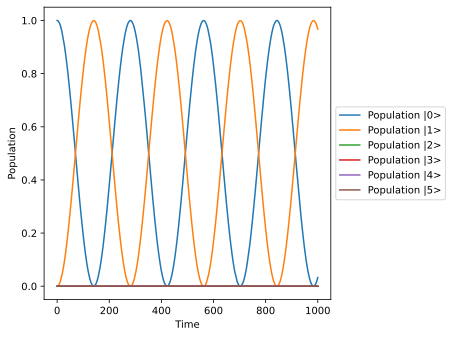

In [122]:
for i in range(levels):
    plt.plot(times, result_levels.expect[i], label=f'Population |{i}>')

plt.xlabel('Time')
plt.ylabel('Population')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  
plt.show()

## Timing

In [123]:
d01 = abs(n_op_energy_basis[0, 1])

rabi_freq = A * d01

tx = np.pi / rabi_freq

tx

140.59238496140256

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

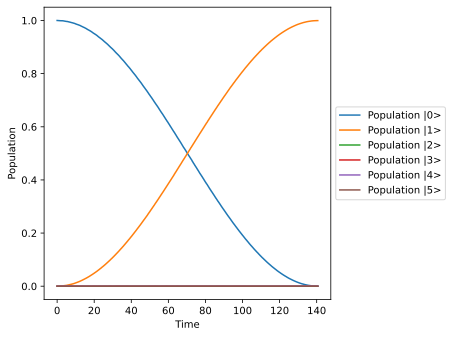

In [124]:
x_test_times = np.linspace(0, tx, 1000) 

result_levels_x_time = qt.mesolve(
    H, psi_initial, x_test_times, [],
    projectors,
    args=args, options=options
)

for i in range(levels):
    plt.plot(x_test_times, result_levels_x_time.expect[i], label=f'Population |{i}>')

plt.xlabel('Time')
plt.ylabel('Population')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  
plt.show()

## Propagator

In [125]:
times = np.linspace(0, tx, 10000)


U = qt.propagator(H, times, args=args, options=options)

# U

In [126]:
U[-1]

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.55319000e-02-5.98550552e-03j -4.05631519e-01-9.13791109e-01j
   2.28916521e-05-1.64650633e-05j -1.06574652e-03+9.70928312e-03j
   8.12355669e-03-3.41924588e-03j -3.30793786e-04+4.50894365e-05j]
 [-9.85831289e-01+1.66201214e-01j -3.58080385e-03-1.62010853e-02j
   8.12861676e-05-7.04944371e-04j  2.07001082e-03+1.20127309e-02j
  -4.43739868e-03+8.44366538e-03j -8.13721874e-05-6.38830845e-04j]
 [-6.71569739e-04+9.92169497e-05j -1.90209664e-05+9.78637795e-06j
  -1.21340222e-01+9.92245800e-01j -3.22439637e-04+2.28804036e-03j
   2.27192975e-05+2.83284358e-05j -2.67574010e-02-2.74226793e-03j]
 [ 1.08952038e-02+4.76086152e-03j  1.20757863e-03+1.00026687e-02j
   8.60433880e-04-2.13467905e-03j -3.91758469e-01+9.19802721e-01j
   1.44126238e-02-7.12050963e-03j  6.12029875e-05+6.28293122e-06j]
 [-9.78949881e-03-7.71960109e-04j  6.54016605e-03+5.53079690e-03j
  -4.96040556e-05+1.47398053e-04j  4.919

In [127]:
U[-1].full()[:2, :2]

array([[ 0.0155319 -0.00598551j, -0.40563152-0.91379111j],
       [-0.98583129+0.16620121j, -0.0035808 -0.01620109j]])

In [128]:
U_final = qt.Qobj(U[-1].full()[:2, :2])

## Fidelity

In [129]:
# X_ideal = qt.qeye(2)
# X_ideal = X_ideal.full()

# X_ideal[0, 0] = 0
# X_ideal[0, 1] = 1
# X_ideal[1, 0] = 1
# X_ideal[1, 1] = 0

# X_ideal = qt.Qobj(X_ideal)

# X_ideal

X_ideal = qt.sigmax()

In [130]:
# redefine the Hamiltonian with the correct drive amplitude

n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))
H0 = qt.Qobj(np.diag(evals))
A = 0.1
drive_op = n_op_energy_basis
omega_d = evals[1] - evals[0]
H = [H0, [A * drive_op, 'cos(wd * t)']]
args = {'wd': omega_d}

In [131]:
U = qt.propagator(H, tx, args=args, options=options)

U

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.55168764e-02-5.98110489e-03j -4.05608843e-01-9.13798303e-01j
   2.29133313e-05-1.64597786e-05j -1.06754566e-03+9.70899141e-03j
   8.12316052e-03-3.41921799e-03j -3.30529398e-04+4.36310124e-05j]
 [-9.85832412e-01+1.66177484e-01j -3.57889517e-03-1.61856735e-02j
   8.13253675e-05-7.04933378e-04j  2.06958517e-03+1.20128751e-02j
  -4.45291489e-03+8.42822592e-03j -8.13887288e-05-6.38787693e-04j]
 [-6.71537255e-04+9.92197996e-05j -1.90188485e-05+9.79680854e-06j
  -1.21396527e-01+9.92231547e-01j -3.22836341e-04+2.28784944e-03j
   2.26530969e-05+2.83271026e-05j -2.67357170e-02-2.79418853e-03j]
 [ 1.08941325e-02+4.76282431e-03j  1.20715402e-03+1.00028334e-02j
   8.60506694e-04-2.13455754e-03j -3.91919868e-01+9.19700516e-01j
   1.44302363e-02-7.09855531e-03j  6.11493808e-05+6.44054416e-06j]
 [-9.78906813e-03-7.71848462e-04j  6.52338573e-03+5.54132563e-03j
  -4.98850512e-05+1.47200227e-04j  5.095

Calculating fidelity: 100%|██████████| 1000/1000 [02:01<00:00,  8.25it/s]


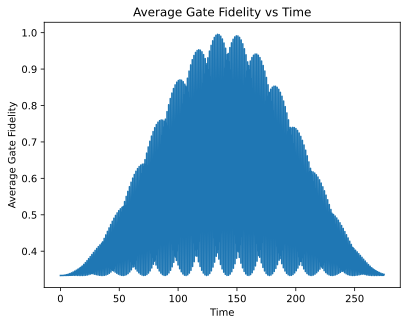

In [132]:
from tqdm import tqdm

iterations = 1000
times = np.linspace(0, 275, iterations)

fid_times = []
fid_values = []
for t in tqdm(times, desc='Calculating fidelity'):
    U_t = qt.propagator(H, t, args=args, options=options)

    U_2lvl = qt.Qobj(U_t.full()[:2, :2])
    fid = qt.average_gate_fidelity(U_2lvl, qt.sigmax())
    
    fid_times.append(t)
    fid_values.append(fid)

plt.plot(np.array(fid_times), np.array(fid_values))
plt.xlabel('Time')
plt.ylabel('Average Gate Fidelity')
plt.title('Average Gate Fidelity vs Time')
plt.show()


In [133]:
peak_fidelity = np.max(fid_values)
print("Peak average gate fidelity:", peak_fidelity)

peak_index = np.argmax(fid_values)
peak_time = times[peak_index]
print("Time at peak fidelity:", peak_time)

tx = peak_time

Peak average gate fidelity: 0.9954831047722944
Time at peak fidelity: 133.50850850850853


## Noise

In [134]:
gamma = 0.1  # damping rate
c_ops = [np.sqrt(gamma) * qt.destroy(levels)]
c_ops

gamma_ij = {}
for j in range(1, levels):
    for i in range(j):
        # Get T1 time for the transition (j -> i)
        t1 = fluxonium.t1_capacitive(j, i)
        if t1 is not None and t1 > 0:
            gamma_ij[(i, j)] = 1.0 / t1

In [135]:
c_ops = []
for (i, j), gamma in gamma_ij.items():
    # |i><j| operator
    cop = (gamma**0.5) * qt.basis(levels, i) * qt.basis(levels, j).dag()
    c_ops.append(cop)

c_ops

[Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=CSR, isherm=False
 Qobj data =
 [[0.         0.00409202 0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]],
 Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=CSR, isherm=True
 Qobj data =
 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]],
 Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=CSR, isherm=False
 Qobj data =
 [[0.        0.        0.        0.        0.        0.       ]
  [0.        0.        0.0005597 0.        0.        0.       ]
  [0.        0.        

In [ ]:
threshold = 1e-4 #was 1e-3

c_ops = [cop for (i, j), gamma in gamma_ij.items() if gamma > threshold
         for cop in [(gamma**0.5) * qt.basis(levels, i) * qt.basis(levels, j).dag()]]


Calculating fidelity: 100%|██████████| 1000/1000 [02:06<00:00,  7.89it/s]


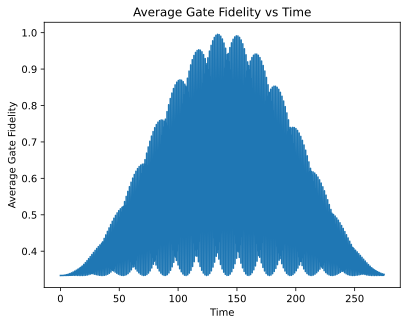

In [137]:
times = np.linspace(0, 275, iterations)

fid_times = []
fid_values = []
for t in tqdm(times, desc='Calculating fidelity'):
    U_t = qt.propagator(H, t,  c_ops=c_ops, args=args, options=options)

    U_2lvl = qt.Qobj(U_t.full()[:2, :2])
    fid = qt.average_gate_fidelity(U_2lvl, qt.sigmax())
    
    fid_times.append(t)
    fid_values.append(fid)

plt.plot(np.array(fid_times), np.array(fid_values))
plt.xlabel('Time')
plt.ylabel('Average Gate Fidelity')
plt.title('Average Gate Fidelity vs Time')
plt.show()


In [138]:
peak_fidelity = np.max(fid_values)
print("Peak average gate fidelity:", peak_fidelity)

peak_index = np.argmax(fid_values)
peak_time = times[peak_index]
print("Time at peak fidelity:", peak_time)

Peak average gate fidelity: 0.9954831047722944
Time at peak fidelity: 133.50850850850853


## Optimal Control

Notes

H0 and drive consistent

Use optimal control and start with H0, keep the native operator but the Acos(wdt) portion is manipulable by methods like grape

- ideal gate = sigma x 

- find ft so that the drive operator creates a propagator that evolves to something close to sigmax or other defined gate